In [578]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt
import itertools

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [579]:
# read in the mesa profile data
model = 34000
star3_prof = ms.mesa_profile(mass=2.0,Z=0.02,num=model)
star3 = ms.star_log(mass=2.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
100 in profiles.index file ...
Found and load nearest profile for cycle 34000
reading /data/nugrid_apod2/data/set1ext/set1.2/see_wind/M2.00Z2.0e-02/LOGS/log20.data ...
 reading ...100% 

Closing profile tool ...
nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 

Closing star.log  tool ...


<IPython.core.display.Javascript object>


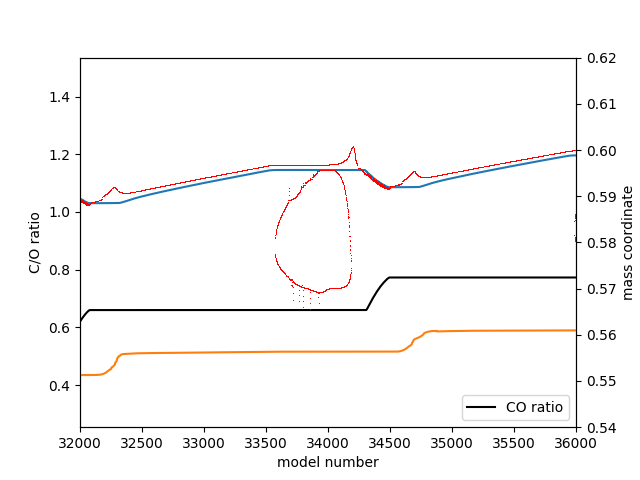

In [580]:
# create a kippenhahn diagram of area of interest
plt.figure(2)
star3.kippenhahn_CO(2,'model')

# set limits
plt.xlim([32000,36000])
plt.ylim([0.54,0.62])

# turn off legend
axis = plt.gca()
axis.get_legend().remove()

The `log_D_mix` variable is the diffusion coefficient that contains the overshoot and is the one used for the stellar models. This is what the hydro D should be compared with.

<IPython.core.display.Javascript object>


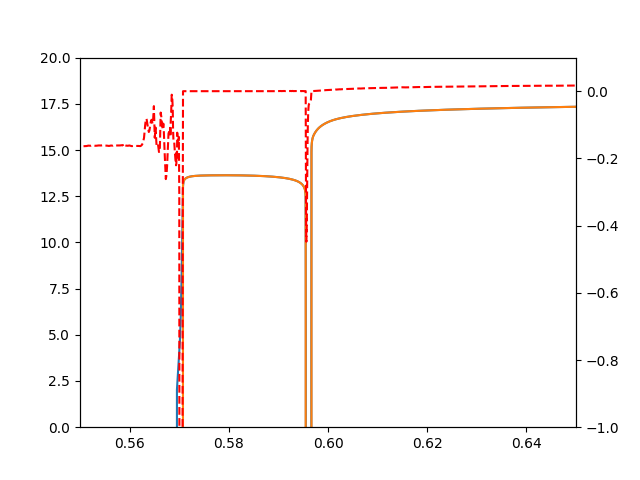

(-1, 0.1)

In [581]:
# get radius and diffusion (check quickly which is total D)
mass = star3_prof.get('mass')
radius = star3_prof.get('radius')
diffusion1 = star3_prof.get('log_D_mix')
diffusion2 = star3_prof.get('log_mlt_D_mix')
entropy = star3_prof.get('entropy')
grad_a = star3_prof.get('grada')
grad = star3_prof.get('gradT')

# mass range
mrange = [0.55,0.65]

# plot
fig = plt.figure(1)
ax1 = fig.add_subplot(111)

ax1.plot(mass,diffusion1)
ax1.plot(mass,diffusion2)
ax2 = ax1.twinx()

ax2.plot(mass,grad - grad_a,'r--')

# set limits
plt.xlim(mrange)
ax1.set_ylim([0,20])
ax2.set_ylim([-1,0.1])

In [588]:
# define the hydro diffusion coefficient 
def overshoot(D0,r0,r,fcbm,Hp):
    
    # Hp is at r0 as well! (NOT at bottom of schwarzschild), this is the convective overshoot
    return D0 * np.exp(- 2 * abs(r - r0) / (fcbm * Hp))

def hydro_D(star_prof):
    
    # star_prof is the mesa profile object of the star of interest at a particular
    # model number
    
    # define constants
    k = 1.38e-23
    G = 6.67e-11
    mh = 1.67e-27
    
    Msun = 1.989e30
    Rsun = 6.95e8
    fcbm = 0.03
    fcbm_low = 0.015
    alpha = 1.6
    
    # get quantities and reverse such that lower indices are towards center
    radius = np.flip(star_prof.get('radius'),0)
    mass = np.flip(star_prof.get('mass'),0)
    mu = np.flip(star_prof.get('mu'),0)
    temperature = np.flip(10**(star_prof.get('logT')),0)
    v_mlt = np.flip(star_prof.get('log_conv_vel'),0)
    model_diffusion = np.flip(star_prof.get('log_D_mix'),0)
    
    # schwarzschild criterion quantities
    grad = np.flip(star_prof.get('gradT'),0)
    grada = np.flip(star_prof.get('grada'),0)
    
    # convert all to SI
    mass *= Msun
    radius *= Rsun
    
    # (keep v_mlt in cm/s)
    v_mlt = 10**(v_mlt)

    # calculate g (SI)
    g = G * mass / np.power(radius,2)
    
    # compute scale height (SI)
    scale_height = k * temperature / (mu * mh * g) 
#     scale_height = star_prof.get('pressure_scale_height') * 1e6
    
    # find where the scwarzschild criterion is
    schwarzschild = grad - grada
    
    # NOTE: mass[0] is at the center of the star!
    convection = np.where(schwarzschild > 0)[0]
    
    # NOTE: only looking at He-flash convection zone
    bounds = []
    for i in range(0,len(convection)-1):
        if convection[i+1] - convection[i] > 1:
            bounds.append(convection[i])
 
    # only bounds IS the end point of convection zone
    schwarz_bounds = [convection[0],bounds[0]]
    
    # get the pressure scale height AT lower boundary (used in MLT)
    Hp = scale_height[schwarz_bounds[0]]
    
    # grab the radii at schwarzschild boundary
    radius_schwarz = [radius[schwarz_bounds[0]],radius[schwarz_bounds[1]]]

    # define r0 (pressure scale height is taken to the bottom of convection zone)
    r0_lower = radius_schwarz[0] + fcbm_low*scale_height[schwarz_bounds[0]]
    r0_upper = radius_schwarz[1] - fcbm*scale_height[schwarz_bounds[1]]
    
    # determine what radii indices are less than or above the r0 conditions
    overshoot_limit = []
    
    # get lower limit
    for i in range(len(radius)):
        if radius[i] > r0_lower:
            overshoot_limit.append(i)
            break
    
    # get upper limit
    for i in range(overshoot_limit[0],len(radius)):
        if radius[i] > r0_upper:
            # grab lower, thats the correct radii
            overshoot_limit.append(i-1)
            break
    # get the scale height at r0's
    scale_height_const_low = scale_height[overshoot_limit[0]]
    scale_height_const_up = scale_height[overshoot_limit[1]]
    
    # find where to start computing diffusion coefficient (logD > 0)
    diff_bounds = np.where(abs(model_diffusion) < 6)
    
    # from looking at data, choose:
    diff_bounds = [diff_bounds[0][0],diff_bounds[0][-2]]
            
    # EXTEND RADIUS OVERSHOOT
    radius_overshoot_low = radius[(diff_bounds[0]-50):overshoot_limit[0]]
    radius_overshoot_up = radius[(overshoot_limit[1] + 1):(diff_bounds[1] + 20)]
    
    # EXTEND MASS
    diff_mass = mass[(diff_bounds[0]-50):(diff_bounds[1] + 20)]
    
    # compute the diffusion coefficient (higher index is LOWER in star)
#     radius_overshoot_low = radius[diff_bounds[0]:(overshoot_limit[0])]
    radius_rcmd = radius[(overshoot_limit[0]):(overshoot_limit[1] + 1)]
    v_mlt_region = v_mlt[(overshoot_limit[0]):(overshoot_limit[1] + 1)]
#     radius_overshoot_up = radius[(overshoot_limit[1] + 1):diff_bounds[1]]
  
    # need to compute middle diffusion first
    diff_rcmd = []
    
    # get median radius
    med_radius = np.median(radius_rcmd)
    med_index = np.argmin(min(med_radius - radius_rcmd))
    
    # get scale heights S
    for i in range(len(radius_rcmd)):
        # r-rsc needs to be symmetric, choose which boundary based on below or above
        # midpoint
#         if i < int(len(radius_rcmd) / 2.):
        if i < med_index:
            # use lower boundary (convert min(args) to cm)
            diff_rcmd.append(v_mlt_region[i] * 100 * min(alpha * Hp,abs(radius_rcmd[i] - radius_schwarz[1])))
        else:
            # use upper boundary
            diff_rcmd.append(v_mlt_region[i] * 100 * min(alpha * Hp,abs(radius_rcmd[i] - radius_schwarz[0])))
    
    # compute the diffusion coefficient AT the overshoot lower limit
#     diff_lower = v_mlt[overshoot_limit[0]] * 100 * min(alpha * Hp, abs(radius[overshoot_limit[0]] - radius_schwarz[0]))
    
    # calculate the overshoot for lower
    diff_overshoot_lower = overshoot(diff_rcmd[0],r0_lower,radius_overshoot_low,fcbm_low,scale_height_const_low)
    
    # calculate the overshoot for upper
    diff_overshoot_upper = overshoot(diff_rcmd[-1],r0_upper,radius_overshoot_up,fcbm,scale_height_const_up)
    
    # create total diffusion list
    diff = list(itertools.chain(diff_overshoot_lower,diff_rcmd,diff_overshoot_upper))
    
    # get mass coordinates used
#     diff_mass = mass[diff_bounds[0]:diff_bounds[1]]
    
    # convert to code units (log D and mass / Msun)
    for i in range(len(diff)):
        diff[i] = np.log10(diff[i])
        diff_mass[i] = diff_mass[i] / Msun
        
    # return diffusion and mass diffusion 
#     return overshoot_limit,schwarz_bounds
    return diff, diff_mass, diff_bounds, overshoot_limit, schwarz_bounds, diff_overshoot_lower
# #     return scale_height_const, overshoot_limit, diff_bounds
#     return diff,diff_mass, diff_bounds, diff_overshoot_lower,r0_lower,radius_overshoot_low, radius_schwarz, schwarz_bounds

<IPython.core.display.Javascript object>


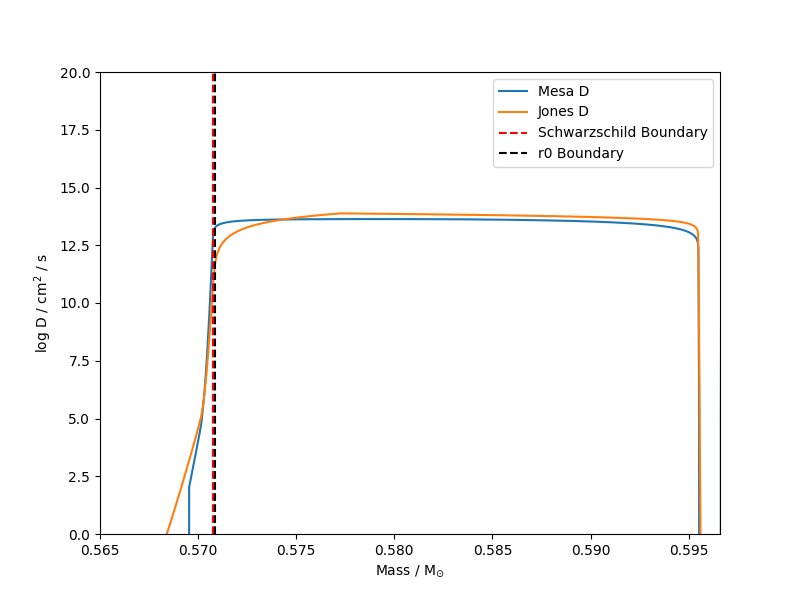

In [589]:
# make a plot of diffusion coefficients
hydro_data = hydro_D(star3_prof)
diff = hydro_data[0]
diff_mass = hydro_data[1]
mass_flip = np.flip(mass,0)

# make figure
fig = plt.figure(45)
fig.set_size_inches(8,6)
ax1 = fig.add_subplot(111)

ax1.plot(mass,diffusion1,label='Mesa D')
ax1.plot(diff_mass,diff,label='Jones D')

# schwarzschild boundary
ax1.axvline(mass_flip[hydro_data[4][0]],color='r',linestyle='--',label='Schwarzschild Boundary')

# r0 boundary
ax1.axvline(mass_flip[hydro_data[3][0]],color='k',linestyle='--',label='r0 Boundary')

# second axis, plot r(m)
ax2 = ax1.twinx()
ax
# ax2.plot(mass,np.log10(radius),'g--',label='Radius')

# limits
ax1.set_xlim([0.565,0.5966])
ax1.set_ylim([0,20])
ax1.set_xlabel('Mass / M$_{\odot}$')
ax1.set_ylabel('log D / cm$^{2}$ / s')

# ax2.set_ylim([-2,0])
# ax2.set_ylabel('log R / R$_{\odot}$')

# set legend
ax1.legend()